# 프로젝트 : 모든  영화 장르 간 편향성 측정해 보기

#### 영화 시놉시스 코퍼스를 이용해 모든 장르의 영화 구분, 장르 간의 편향성을 측정하는 프로젝트

- WEAT score를 이해하고, 단어 임베딩 간의 편향성(관계)측정하는 메커니즘을 이해한다.
- 영화 시놉시스 데이터를 전처리한다.
- 해당 프로젝트에서 개선점을 찾는다.

1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. target, attribute 단어 셋 만들기
4. WEAT score 계산과 시각화

### 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [1]:
import os
from gensim.models import Word2Vec

In [2]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [3]:
# 약 6분 소요
from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ['Noun']:  # "Adjective", "Verb" 등을 포함할 수 있다.
                res.append(w[0])  # 명사일 때만 tokenized에 저장하게 된다.
            tokenized.append(res)

[0.012s][warning][os,thread] Attempt to protect stack guard pages failed (0x00000001693f0000-0x00000001693fc000).
[0.012s][warning][os,thread] Attempt to deallocate stack guard pages failed.


In [4]:
print(len(tokenized))

3168454


### 추출된 결과로 embedding model 만들기

- Word2Vec의 하이퍼파라미터 값
    - size = 워드 벡터의 특징, 임베딩 된 벡터의 차원
    - window = 컨텍스트 윈도우 크기
    - min_count = 단어 최소 빈도 수 제한(빈도가 적은 단어는 학습하지 않음)
    - workers = 학습을 위한 프로세스 수
    - sg = 0 은 CBOW, 1은 Skip-gram

In [5]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 3.X 기준))
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)

In [6]:
model.wv.most_similar(positive=['희망'])

[('나락', 0.5314304232597351),
 ('희망이', 0.520393967628479),
 ('현실', 0.49150341749191284),
 ('무게', 0.43800678849220276),
 ('열망', 0.4297703504562378),
 ('티샤', 0.39990729093551636),
 ('사박', 0.3982659578323364),
 ('우사인볼트', 0.39516210556030273),
 ('김준평', 0.39355477690696716),
 ('선택', 0.39183518290519714)]

In [7]:
model.wv.most_similar(positive=['절망'])

[('상실', 0.5083270072937012),
 ('자괴', 0.5057387948036194),
 ('서러움', 0.4822075068950653),
 ('허탈', 0.4669780135154724),
 ('슬픔', 0.4648779630661011),
 ('친밀', 0.46348315477371216),
 ('나락', 0.448272168636322),
 ('현대인', 0.4432859718799591),
 ('공포', 0.4408835172653198),
 ('자책', 0.44026094675064087)]

- Skip-gram 방식을 적용하면 어떻게 되는지 시도해 보자.

In [8]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 3.X 기준))
model_sg = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=1)

In [9]:
model_sg.wv.most_similar(positive=['희망'])

[('아난', 0.5194205641746521),
 ('모퍼고', 0.5011045932769775),
 ('스팀펑크', 0.4964439272880554),
 ('삼계', 0.4925196170806885),
 ('불리웠', 0.4897879958152771),
 ('오시리스', 0.4894554316997528),
 ('대한', 0.4848470389842987),
 ('어인', 0.4802996516227722),
 ('어거스티', 0.46800345182418823),
 ('앙카라', 0.46732184290885925)]

In [10]:
model_sg.wv.most_similar(positive=['절망'])

[('앙카라', 0.5362334847450256),
 ('을해', 0.482941210269928),
 ('모스코바', 0.4717141389846802),
 ('맞닥트린', 0.4692533612251282),
 ('성취', 0.46778759360313416),
 ('희망', 0.4666489064693451),
 ('낙지', 0.46604228019714355),
 ('틴저', 0.4651341438293457),
 ('감', 0.4649539589881897),
 ('레스보스', 0.4640715420246124)]

### target, attribute 단어 셋 만들기


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [12]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line:
                break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ['Noun']:
                    result.append((word[0]))
    return ' '.join(result)

In [13]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [14]:
# TFIDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [15]:
m1 = X[0].tocoo() #- # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i,j] for i,j in zip(m1.col, m1.data)]
w2 = [[i,j] for i,j in zip(m2.col, m2.data)]

w1.sort(key=lambda x:x[1], reverse=True) #- art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x:x[1], reverse=True) #- gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')
    
print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')  

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [16]:
# CBOW
n = 15

w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])
    
#- w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어 15개를추출합니다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [17]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [18]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [19]:
# Skip-Gram
n = 15

w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])
    
#- w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어 15개를추출합니다.
target_art_sg, target_gen_sg = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model_sg.wv): target_art_sg.append(w1_[i])
    if len(target_art_sg) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model_sg.wv): target_gen_sg.append(w2_[i])
    if len(target_gen_sg) == n: break

In [20]:
print(target_art_sg)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [21]:
print(target_gen_sg)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


### attribute 단어 셋

In [22]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [23]:
print(len(genre_txt), len(genre_name))

21 21


In [24]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [25]:
# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [26]:
# CBOW
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
    
attributes = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print('\n')
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 


가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 


공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 


공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 


기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 


다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 


드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 


멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 


뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 


미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 


범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 


사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 


서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 에머슨, 무법자, 프린트, 


성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀,

In [27]:
# Skip-Gram
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
    
attributes_sg = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model_sg.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes_sg.append(attr)
    print('\n')
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 


가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 


공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 


공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 


기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 


다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 


드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 


멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 


뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 


미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 


범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 


사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 


서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 에머슨, 무법자, 프린트, 


성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀,

### WEAT score 계산과 시각화
- traget_X는 art, target_Y는 gen으로 고정
- attribute A, B는 21개 장르의 조합으로 설정
- 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고
- 이를 Heatmap 형태로 시각화해 봅니다.
- 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 
- 시각적으로 두드러지게 구성되면 좋습니다.

In [28]:
from numpy import dot
from numpy.linalg import norm

In [29]:
def cos_sim(i, j):
    return dot(i, j.T) / (norm(i) * norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [30]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [31]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j], matrix[i][j])

SF 가족 -0.84855163
SF 사극 -1.3133646
SF 어드벤처 -0.88728917
가족 기타 0.89977944
가족 다큐멘터리 0.9824984
가족 애니메이션 1.0805153
공연 기타 1.0265896
공연 다큐멘터리 1.0468936
공연 애니메이션 0.92698336
공포(호러) 다큐멘터리 0.83836174
기타 다큐멘터리 0.8614196
기타 드라마 -1.0280052
기타 멜로로맨스 -0.8949689
기타 사극 -0.99591374
기타 어드벤처 -0.85245925
기타 코미디 -0.8362427
다큐멘터리 드라마 -0.9760545
다큐멘터리 멜로로맨스 -0.9122661
다큐멘터리 뮤지컬 -1.1574006
다큐멘터리 미스터리 -0.82007205
다큐멘터리 사극 -1.0727471
다큐멘터리 서부극(웨스턴) -0.86573243
다큐멘터리 어드벤처 -0.9799831
다큐멘터리 코미디 -0.9184468
다큐멘터리 판타지 -0.9523923
드라마 애니메이션 0.928907
멜로로맨스 성인물(에로) 1.1710588
멜로로맨스 애니메이션 0.83214104
미스터리 범죄 0.9003751
범죄 스릴러 -0.8250496
사극 애니메이션 0.9950919
사극 전쟁 1.0197834
사극 판타지 0.84714276
애니메이션 어드벤처 -0.9858097
애니메이션 코미디 -0.8056723


In [32]:
# Skip-Gram
matrix_sg = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X_sg = np.array([model_sg.wv[word] for word in target_art])
Y_sg = np.array([model_sg.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A_sg = np.array([model_sg.wv[word] for word in attributes_sg[i]])
        B_sg = np.array([model_sg.wv[word] for word in attributes_sg[j]])
        matrix_sg[i][j] = weat_score(X_sg, Y_sg, A_sg, B_sg)

In [33]:
# Skip-Gram
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_sg[i][j] > 0.8 or matrix_sg[i][j] < -0.8:
            print(genre_name[i], genre_name[j], matrix_sg[i][j])

SF 공포(호러) -1.0001163
SF 다큐멘터리 0.81036216
SF 멜로로맨스 -0.8250591
SF 미스터리 -1.0602818
SF 스릴러 -0.8936203
SF 어드벤처 -0.99122596
가족 공포(호러) -0.8022458
가족 기타 1.0188167
가족 다큐멘터리 1.0967714
가족 애니메이션 0.9815066
공연 기타 0.97282934
공연 다큐멘터리 1.1265981
공연 뮤지컬 1.0022894
공연 애니메이션 0.9377128
공포(호러) 기타 0.9934746
공포(호러) 다큐멘터리 1.0724047
공포(호러) 드라마 0.85705286
공포(호러) 뮤지컬 0.92171776
공포(호러) 서부극(웨스턴) 1.0464104
공포(호러) 애니메이션 0.9661777
공포(호러) 판타지 0.8834662
기타 드라마 -1.0468636
기타 멜로로맨스 -0.93627465
기타 뮤지컬 -0.84343004
기타 미스터리 -0.94622934
기타 사극 -0.9051475
기타 스릴러 -0.87027156
기타 어드벤처 -1.0150483
기타 코미디 -0.99752
기타 판타지 -0.93752795
다큐멘터리 드라마 -1.126392
다큐멘터리 멜로로맨스 -0.9901954
다큐멘터리 뮤지컬 -1.0718026
다큐멘터리 미스터리 -1.0262188
다큐멘터리 범죄 -0.81195134
다큐멘터리 사극 -1.0256
다큐멘터리 서부극(웨스턴) -0.9063179
다큐멘터리 성인물(에로) -0.86061585
다큐멘터리 스릴러 -0.94994956
다큐멘터리 액션 -0.9043323
다큐멘터리 어드벤처 -1.1544055
다큐멘터리 전쟁 -0.96292835
다큐멘터리 코미디 -1.0753611
다큐멘터리 판타지 -1.0969932
드라마 미스터리 -0.81119627
드라마 애니메이션 0.9830529
드라마 어드벤처 -0.8384545
드라마 코미디 -0.8330246
멜로로맨스 뮤지컬 0.85289717
멜로로맨스 

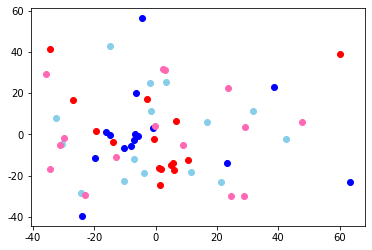

In [34]:
# PCA를 통해 5차원 벡터 => 2차원 벡터로 줄여 시각화

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots()
ax.scatter(pc_A[:,0], pc_A[:, 1], c='blue', label='A')
ax.scatter(pc_B[:,0], pc_B[:, 1], c='red', label='B')
ax.scatter(pc_X[:,0], pc_X[:, 1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0], pc_Y[:, 1], c='hotpink', label='Y')

<AxesSubplot:>

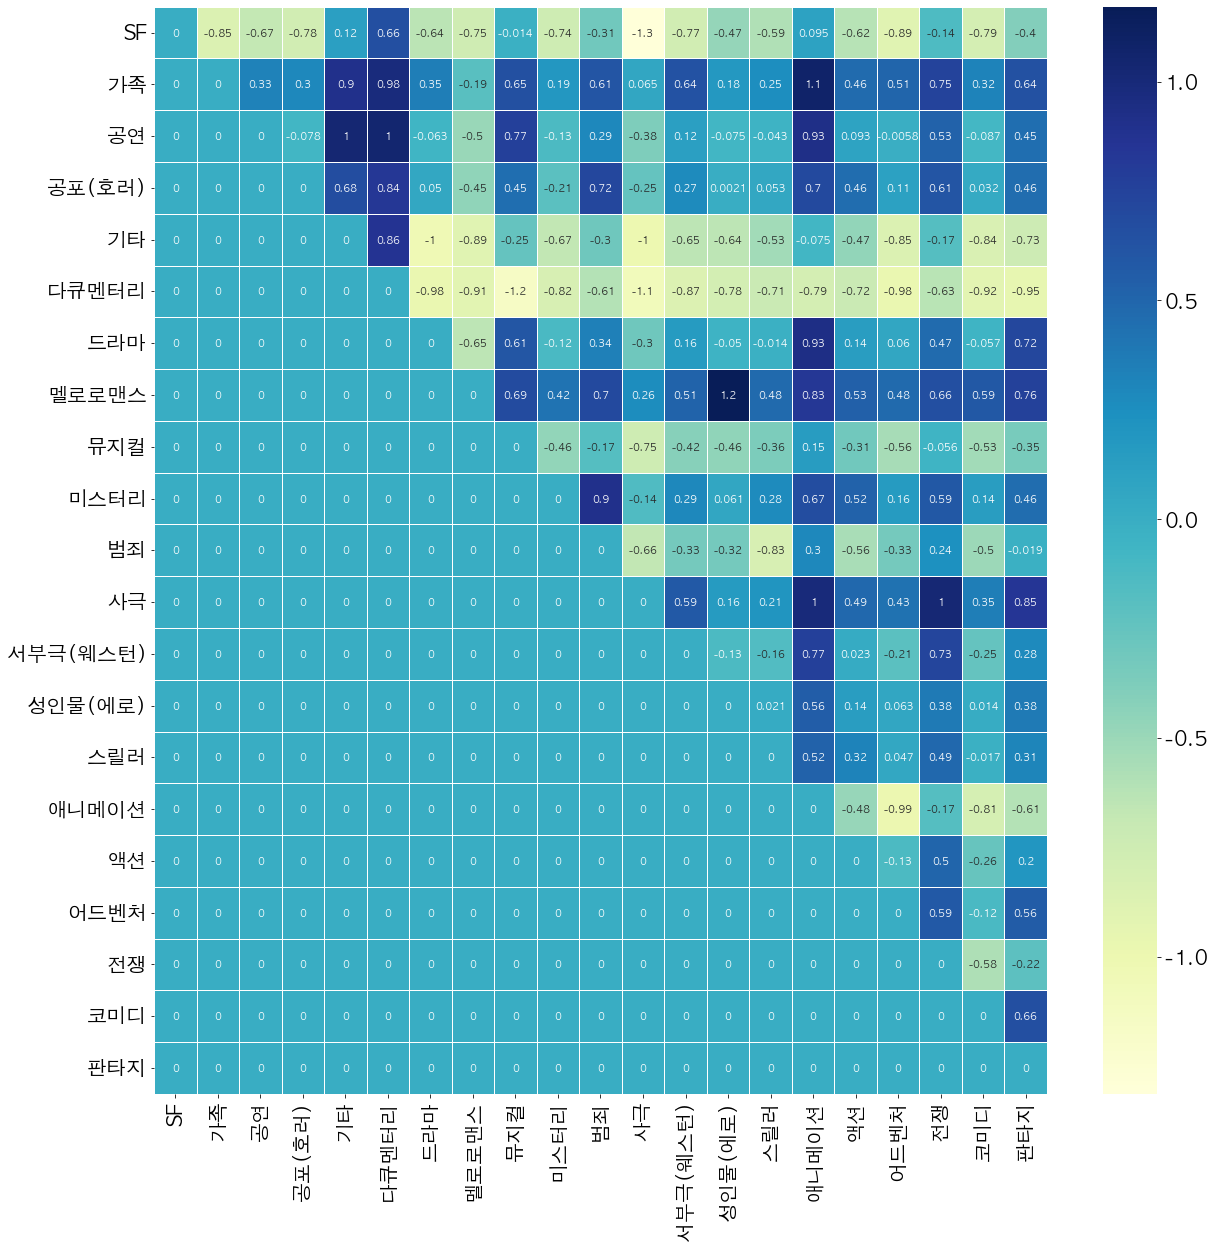

In [35]:
import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트

plt.figure(figsize=(20, 20))
# sns.set(font = "NanumGothic")
plt.rcParams['font.family'] = 'AppleGothic'

# 그래프 내부의 글꼴 크기
# plt.rcParams['font.size'] = 12

# x 및 y 레이블의 글꼴 크기
# parameters = {'axes.labelsize': 25, 'axes.titlesize': 35}

# 눈금 레이블의 글꼴 크기
parameters = {'xtick.labelsize': 20,
              'ytick.labelsize': 20}
plt.rcParams.update(parameters)

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix,
                 xticklabels=genre_name,
                 yticklabels=genre_name,
                 linewidths=.5,
                 annot=True,
                 cmap="YlGnBu")
ax

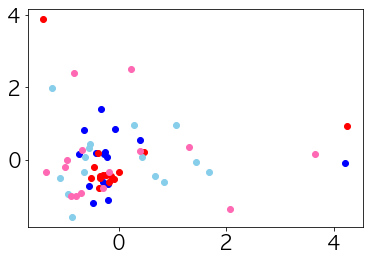

In [36]:
# Skip-Gram - PCA를 통해 5차원 벡터 => 2차원 벡터로 줄여 시각화

from sklearn.decomposition import PCA

pca_sg = PCA(n_components=2)
pc_sg_A = pca_sg.fit_transform(A_sg)
pc_sg_B = pca_sg.fit_transform(B_sg)
pc_sg_X = pca_sg.fit_transform(X_sg)
pc_sg_Y = pca_sg.fit_transform(Y_sg)

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots()
ax.scatter(pc_sg_A[:,0], pc_sg_A[:, 1], c='blue', label='A')
ax.scatter(pc_sg_B[:,0], pc_sg_B[:, 1], c='red', label='B')
ax.scatter(pc_sg_X[:,0], pc_sg_X[:, 1], c='skyblue', label='X')
ax.scatter(pc_sg_Y[:,0], pc_sg_Y[:, 1], c='hotpink', label='Y')

<AxesSubplot:>

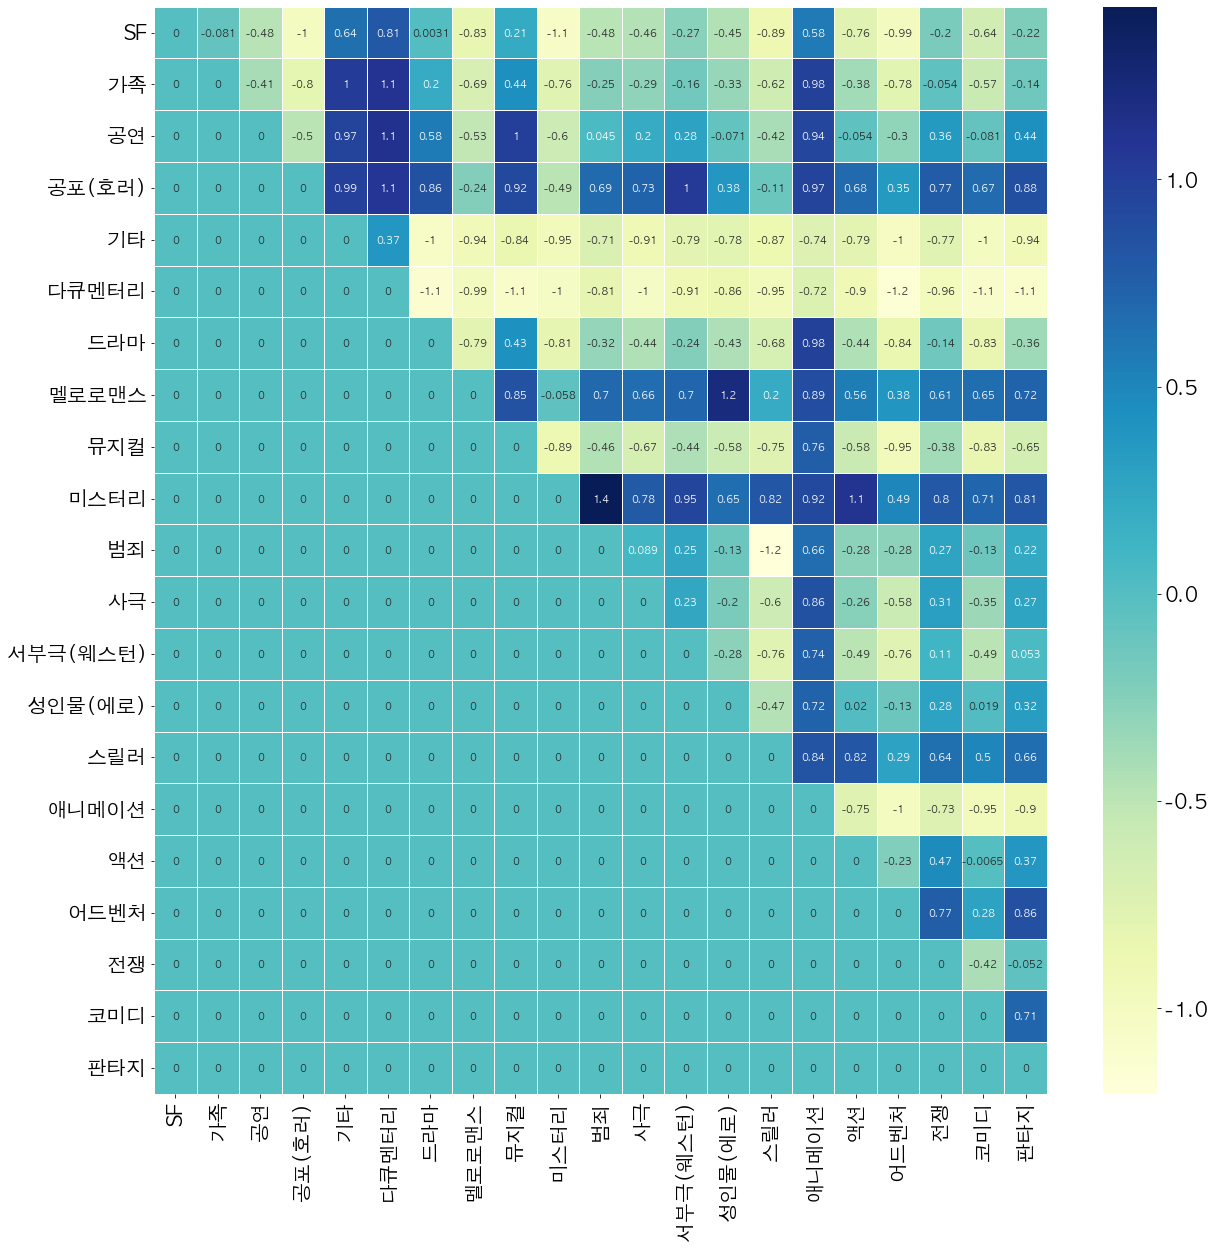

In [37]:
# Skip-Gram

import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트

plt.figure(figsize=(20, 20))
# sns.set(font = "NanumGothic")
plt.rcParams['font.family'] = 'AppleGothic'

# 그래프 내부의 글꼴 크기
# plt.rcParams['font.size'] = 12

# x 및 y 레이블의 글꼴 크기
# parameters = {'axes.labelsize': 25, 'axes.titlesize': 35}

# 눈금 레이블의 글꼴 크기
parameters = {'xtick.labelsize': 20,
              'ytick.labelsize': 20}
plt.rcParams.update(parameters)

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix_sg,
                 xticklabels=genre_name,
                 yticklabels=genre_name,
                 linewidths=.5,
                 annot=True,
                 cmap="YlGnBu")
ax

### 회고

### WEAT 결과 해석(sg=0일 경우)

- WEAT score가 0.8 이상, -0.8이하인 경우만 해석해봅니다.
- WEAT score가 양수일 경우, 해당 단어가 Attribute A와 가깝다는 것이고, 음수가 나오면 Attribute B와 가깝다는 의미입니다.
    - 음수
        - SF  : 가족, 사극, 어드벤처
        - 기타 : 드라마, 멜로로맨스, 사극, 어드벤처, 코미디
        - 다큐 : 드라마, 멜로로맨스, 뮤지컬, 미스테리, 사극, 서부극, 어드벤쳐, 코미디, 판타지
        - 범죄 : 스릴러
        - 애니메이션 : 어드벤처, 코미디
            - 예술영화 : 가족, 사극, 어드벤처, 드라마, 멜로로맨스, 코미디, 뮤지컬, 미스테리, 서부극, 스릴러, 판타지 
            - 일반영화 : SF, 다큐, 범죄, 애니메이션, 기타
        
    - 양수
        - 가족 : 기타, 다큐멘터리, 애니메이션
        - 공연 : 기타, 다큐멘터리, 애니메이션
        - 공포(호러) : 다큐멘터리
        - 기타 : 다큐멘터리
        - 드라마 : 애니메이션
        - 멜로로멘스 : 성인물(에로), 애니메이션
        - 미스터리 : 범죄
        - 사극 : 애니메이션, 전쟁, 판타지
            - 예술영화 : 가족, 공연, 공포(호러), 기타, 드라마, 멜로로멘스, 미스터리, 사극
            - 일반영화 : 기타, 다큐멘터리, 애니메이션, 성인물(에로), 범죄, 전쟁, 판타지
            
            
- WEAT score의 절대값이 클수록 두 개념축 사이의 편향성이 크다는 의미입니다.
    - `SF-사극`, `멜로로맨스-성인물(에로)`, `다큐멘터리-뮤지컬, 사극`, `사극-전쟁`은 상대적으로 __편향성__이 큽니다(절대값 1 이상)
    - 위 히트맵에서 `남색(양수)`, `노랑(음수)`인 경우 장르간의 __편향성__이 큽니다.
    
### WEAT 결과 해석(sg=1일 경우)

- 이 경우는 코딩의 오류인지 해석을 하기 난해하고 앞뒤가 서로 맞지 않는 결과를 보인 것으로 판단되었다.

### 시도했던 것

- 노드에서는 word2vec 생성시 `sg=0`(CBOW)로 적용하였기에 `sg=1`(Skip-gram)은 어떤 결과가 나올지 궁금하여 적용해 보았다.
- `'희망'`과 `'절망'`으로 각각 유사 단어 출력을 해보았을 때 Skip-gram 은 엉뚱한 단어들이 출력되어 의아한 생각이 들었다.
- 코딩이 잘못되었을지도 모른다는 생각과 함께 왜 그럴까? 하는 의문만 남긴채 프로젝트를 마무리 한 것 같다.
- 그래도 heatmap까지 계속 진행해 보았지만 역쉬 제대로 된 결과를 만들지 못한 것 같다.


- heatmap 표현시 한글 폰트 문제로 인해 구글링을 통해 해결하였다.
    - [[matplotlib/seaborn]한글 깨짐 문제 해결](https://sks8410.tistory.com/38)
    
    
- 한글 폰트 문제 및 레이블 텍스트 size도 다양하게 변경하며 최적의 size로 표현하기 위해 노력하였다.
- 위 링크 및 아래 주석 내용을 참조 바랍니다.

```
# 폰트 리스트 확인
import matplotlib.font_manager as fm

font_list = [font.name for font in fm.fontManager.ttflist]
font_list

# 그래프 내부 폰트 크기 조정
plt.rcParams['font.size'] = 23
```

In [38]:
# import matplotlib.font_manager as fm

# font_list = [font.name for font in fm.fontManager.ttflist]
# print(len(font_list))
# font_list[::20]